# AWS Cloud: getting started and retrieving ECCO datasets

Andrew Delman, updated 2024-10-18.

## Introduction
Previous tutorials have discussed how to download ECCO datasets from PO.DAAC to your local machine. However, during 2021-2022 PO.DAAC datasets (including ECCO) migrated to the NASA Earthdata Cloud hosted by Amazon Web Services (AWS). While data downloads from the cloud (using wget, curl, Python requests, etc.) function like downloads from any other website, there are definite advantages to working with datasets within the cloud environment. Data can be opened in an S3 bucket and viewed without downloading, or can be quickly downloaded to a user's cloud instance for computations. For more information on PO.DAAC datasets in the cloud, there are [a number of infographics here](https://podaac.jpl.nasa.gov/cloud-datasets/about).

This tutorial will walk through the steps of how a user can set up an AWS instance and access ECCO datasets for computations in that instance. No prior experience with the AWS cloud is assumed.

## Set up an AWS cloud instance
Computations in the AWS Cloud are typically done in an Amazon Elastic Compute Cloud (EC2) instance, which is a self-contained computing environment like the operating system on your local machine. You start an EC2 instance through the AWS Cloud management console, then connect to the instance (e.g., through `ssh`) like you would to any other machine, install the software that you need, and start working. AWS offers a [Free Tier](https://aws.amazon.com/ec2/?did=ft_card&trk=ft_card) that provides 750 compute hours per month, 1 GB memory, and up to 30 GB storage for a period of 12 months. This is great for experimenting, but these memory/storage limits can be quite restrictive, so if you have institutional or project support for larger instances it is highly recommended to use them.

The steps here mostly follow this [excellent tutorial on the PO.DAAC Cookbook](https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html). 

### Step 1: Create an AWS account
If you don't already have one, [create an account on AWS](https://portal.aws.amazon.com/billing/signup#/start/email). Anyone with an e-mail address and a credit card can do this, though for the reasons above it is recommended that you seek out institutional support if possible, or include cloud computing costs in your grant proposals.

### Step 2: Start an EC2 instance

> Note: if you have an AWS account through the Jet Propulsion Laboratory (JPL), you will need to do Steps 2 and 3 differently. Please consult [these instructions](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/blob/master/Cloud_Setup/JPL_setup_instructions.md).

Once you [log in](https://console.aws.amazon.com/) to your new account, you should be at a screen with the title Console Home. First, let's make sure you are in the most optimal AWS "region" for accessing PO.DAAC datasets, which are hosted in region *us-west-2 (Oregon)*. In the upper-right corner of the page just to the left of your username, there is a drop-down menu with a place name on it. Select the **US West (Oregon)    us-west-2** region.

Now let's start a new EC2 instance. Click on **Services** in the upper-left corner next to the AWS logo, then **Compute** --> **EC2**. On this new screen where there are a number of boxes, select the yellow **Launch instance** button. There are some settings on this screen to configure before launching the new instance:

*Name and tags*: Whatever you want (e.g., ECCO tutorials).

*Application and OS images (Amazon Machine Image)*: **Quick Start** --> **Red Hat** --> **Red Hat Enterprise Linux 9, SSD Volume Type**
This is not the only AMI you can use, and your institution may have preferred or required AMIs to use AWS cloud services. Make sure that the AMI you select runs Linux, and is "Free tier eligible" if you are not supported by your institution or project.

*Instance type*: **t2.micro** if using the Free tier. If you're not restricted to the free tier, a **t2.medium**/**t3.medium** or larger is recommended. (**t3** is a newer generation, with similar or slightly cheaper costs as **t2**.)

*Key pair (login)*: Click on **Create new key pair**. In the pop-up window, make the name whatever you want (e.g., aws_ec2_jupyter), select *Key pair type*: **RSA** and *Private key file format*: **.pem**, then **Create key pair**. This downloads the key file to your Downloads folder, and you should move it to your `.ssh` folder: `mv ~/Downloads/aws_ec2_jupyter.pem ~/.ssh/`. Then change the permissions to read-only for the file owner `chmod 400 ~/.ssh/aws_ec2_jupyter.pem`.

*Network settings*: Your institution may have existing security groups that you should use, so click the **Select existing security group** and check with your IT or cloud support to see if there are recommended security groups/VPCs to use. If not or you are doing this on your own, then click **Create security group**, which will create a new security group with a name like *launch-wizard-1*. Make sure that the boxes to allow SSH, HTTPS, and HTTP traffic are checked.

*Configure storage*: Specify a storage volume with at least **15 GiB gp3** as your root volume. This is important, since the python/conda installation with the packages we need will occupy ~7.5 GB, and we need some workspace as a buffer. If you are in Free tier then you can request up to 30 GB across all your instances, so you can use up the full amount in a single instance or split it across two instances with 15 GB each.

*Advanced details*: Depending on your security/institutional requirements, you may need to include a specific IAM profile. Check the *IAM instance profile* dropdown menu to see if there is one associated with your security group.

Finally, at the bottom-right of the page click the yellow **Launch instance** button. Wait a minute or two for the instance to initialize; you can check the **Instances** screen accessed from the menu on the left side to see that your Instance state is **Running**.

### Step 3: Install software and set up conda environment

Since your instance starts with a very bare-bones Linux OS, you will need to install software (conda/miniconda/miniforge) to run Python, and then install Python packages and the Jupyter interface to run these tutorial notebooks. A shell script to expedite this process is provided on the tutorial Github page, and here we will walk through setting this up.

First, ssh into your new instance. For most users this will be at the public IPv4 address on the AWS instance summary page, e.g., if the IP address is 35.24.135.171, then: 

```
ssh -i "~/.ssh/aws_ec2_jupyter.pem" ec2-user@35.24.135.171 -L 9889:localhost:9889
```

Some users with an institutional network or VPN might use the private IP address instead. The `-L` option indicates a tunnel from the local machine's port 9889 to the instance's port 9889; this will be used later to open Jupyterlab through your local machine's web browser.

> Tip: If you are having difficulty connecting to your new instance, you might need to change your network/security group settings to allow SSH traffic from your local machine and/or HTTPS/HTTP traffic. Alternatively, you may need to [attach an IAM role to your instance](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/iam-roles-for-amazon-ec2.html).

Now we will update the OS on the instance and install `git` so that we can clone the [ECCOv4 Python tutorial repository](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial). This repository includes a shell script that can be used to finish setting up our workspace. First copy and paste the following commands into the instance's terminal window, and execute:

```
sudo dnf update -y && sudo dnf install git -y && cd ~ && git clone https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial.git
```

Now we will execute a shell script in the Github repository we just cloned, `jupyter_env_setup.sh`. This script handles most of our environment setup, by doing the following:

1. Installing `wget` (which allows us to download from internet websites)

1. Installing `tmux` (which allows us to persist tasks on a remote machine even when disconnected).

1. Downloading `Miniforge.sh` from *conda-forge* which enables us to install `conda` and `mamba` (a faster, C-based `conda`) in the `/tmp` directory.

1. Creating a new conda environment called `jupyter` that will contain the packages we need to run the notebooks.

1. Installing Python packages using a combination of `mamba` and `pip` (the latter works better when memory is limited).

1. Querying the user for their NASA Earthdata username and password (if these are already archived in a `~/.netrc` file this step is skipped).

To run `jupyter_env_setup.sh`, copy, paste, and execute the following two commands on the instance:

```
sudo chmod 755 ~/ECCO-v4-Python-Tutorial/Cloud_Setup/jupyter_env_setup.sh && ~/ECCO-v4-Python-Tutorial/Cloud_Setup/jupyter_env_setup.sh
```

The script takes a few minutes to run, but it should set up our environment with the packages we need, even within the memory constraints of a free-tier t2.micro instance.

### Step 4: Start a Jupyter lab session

With the `jupyter` environment set up and credentials archived, we can run one more shell script to start a Jupyter lab session on the instance. The session will be opened using a `tmux` window; `tmux` is a program (similar to `screen`) that allows a session to be detached from the user's window to run in the background, and persist on a remote machine even after the user disconnects. The previous script created a symbolic link in the home directory that allows us to launch a Jupyterlab session easily after log in. Execute the following in the instance:

```
~/jupyter_lab_start.sh
```

You will get a prompt for a password (optional), or you can leave it blank and press enter. After this is done (and while still connected to your instance through port 9889), open up a window in your local machine's web browser and put ``http://127.0.0.1:9889/`` or ``http://localhost:9889/`` in the URL field. If you set a password for your session enter it when prompted, or if there is no password just click **Log in**. A Jupyter lab should open up in the ECCOv4 tutorial Github repository on your instance. Go to the **Tutorials_as_Jupyter_Notebooks** directory, and you will see a number of notebooks ready to run! For example, you can access this one at *AWS_Cloud_getting_started.ipynb*.

## Reconnecting to your instance and Jupyter lab

### Re-connecting to an active Jupyter lab session

When you start a Jupyter lab session with `~/jupyter_lab_start.sh`, the session persists even after you disconnect from your instance. So in order to re-connect to your active session on the cloud, all you need to do is use a terminal window to re-connect to your instance, e.g.:

```
ssh -i "~/.ssh/aws_ec2_jupyter.pem" ec2-user@instance_ip_address -L 9889:localhost:9889
```

and then open ``http://localhost:9889/`` in your local machine's web browser again.

### Stop/start your instance and starting a new Jupyter lab session

If you will not be working in your instance for a little while, it is a good idea to stop the instance to save on potential AWS computing costs, and then start it again when you resume work. The instance will *hibernate*, and usage and data transfer fees will not be incurred, though volume (storage) fees will still be incurred by a stopped instance if applicable.

Instances can be stopped and started through your [AWS web console](https://console.aws.amazon.com/). To stop an instance, go to **EC2** --> **Instances**, then select the checkbox next to your instance and use the **Instance state** drop-down menu to **Stop instance**. When you are ready to start working again, you will go to the same menu and select **Start instance**, and wait about 1-3 minutes for the instance to run again. There is also an [AWS command line interface (CLI)](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-getting-started.html) that you can use to [list](https://docs.aws.amazon.com/cli/latest/reference/ec2/describe-instances.html), [stop](https://docs.aws.amazon.com/cli/latest/reference/ec2/stop-instances.html), and [start](https://docs.aws.amazon.com/cli/latest/reference/ec2/start-instances.html) instances.  When your instance is running again, you should be able to connect, e.g.:

```
ssh -i "~/.ssh/aws_ec2_jupyter.pem" ec2-user@instance_ip_address -L 9889:localhost:9889
```

Note that the instance's public IP address may have changed when the instance was stopped and started again. Once connected to your instance you will need to start a new Jupyter lab session by running:

```
~/jupyter_lab_start.sh
```

and then you can open ``http://localhost:9889/`` in your local machine's web browser and start working again.


## Accessing ECCO datasets

One nice aspect of working in the cloud where ECCO output is hosted is that you don't need to download and store the output on your local machine. The output is hosted in **S3**, the AWS Cloud's massive storage system, and you can load the output into your notebook workspace and scripts directly from S3. However, if you are doing multiple computations with the same dataset(s), you will likely save time by copying it to your instance's local storage. The *ecco_s3_retrieve* Python module (which is similar to the *ecco_download* module for downloading ECCO datasets) allows us to both open the files directly from S3 and to make a copy of the files on your instance.

Here we'll use both access methods to compute the global mean ocean temperature from ECCOv4, for the 12 months in the year 2010, and log the time it takes to retrieve the files and perform the computation. We'll also try using multiple threads and processes to carry out the computation in parallel using `dask.distributed` (note that you can't benefit from this capability on *t2.micro* and *t2.small* instances as they only have 1 vCPU).

> **Short summary**: in most cases (including the case below), it is quicker to download files to your instance before using them for computations (i.e., Method 2 below). But method 2 can only be used if you have the storage space available on your instance. A function is included in *ecco_s3_retrieve* which helps the user determine if there is sufficient storage available to download files, see **Optimizing data access with available instance storage** below.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import ecco_access as ea

import time

Let's look at the syntax of the `ecco_podaac_access` function. We will try accessing ECCO output using two different access modes: `s3_open` and `s3_get`.

In [2]:
help(ea.ecco_podaac_access)

Help on function ecco_podaac_access in module ecco_access.ecco_access:

ecco_podaac_access(query, version='v4r4', grid=None, time_res='all', StartDate=None, EndDate=None, snapshot_interval=None, mode='download_ifspace', download_root_dir=None, **kwargs)
    This function queries and accesses ECCO datasets from PO.DAAC. The core query and download functions are adapted from Jupyter notebooks 
    created by Jack McNelis and Ian Fenty 
    (https://github.com/ECCO-GROUP/ECCO-ACCESS/blob/master/PODAAC/Downloading_ECCO_datasets_from_PODAAC/README.md)
    and modified by Andrew Delman (https://ecco-v4-python-tutorial.readthedocs.io).
    
    Parameters
    ----------    
    query: str, list, or dict, defines datasets or variables to access.
           If query is str, it specifies either a dataset ShortName (if query 
           matches a NASA Earthdata ShortName), or a text string that can be 
           used to search the ECCO ShortNames, variable names, and descriptions.
           A q

### Method 1: Opening ECCO datasets from S3

To open ECCO output data without saving it into our instance's storage, we use mode = `s3_open`. Note that we supply to `ecco_podaac_access` the **ShortName** of the dataset that we are accessing. If you [don't know the ShortName already](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#What-if-you-don't-know-the-ShortName-already?) you can look for the dataset that you want in [these lists](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/tree/master/varlist), or you can query the variable names and descriptions with a text string. In this case we will use the ShortName of the dataset containing `THETA`, the potential temperature variable.

#### Method 1a: Open using no parallelization (1 thread, 1 process)

First we use only 1 thread and 1 process to open the files and do the computation. Note that when we open the files in the workspace using `open_mfdataset`, the chunks option is used to organize the data into 1 chunk per time coordinate (month). This saves time on the computation which involves summing/averaging over every dimension except time.

{'ShortName': 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2010-01-02,2010-12-31'}

Total number of matching granules: 12
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '1992-01-01,2017-12-31'}

Total number of matching granules: 1


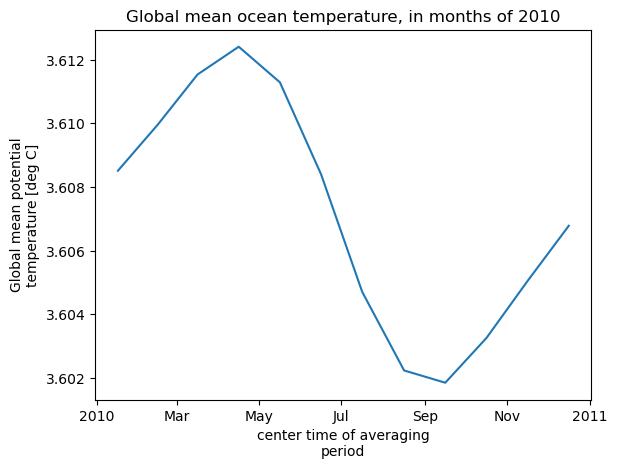



Computation completed
Time to open files, 1 process/1 thread: 35.65613341331482 s
Time to compute, 1 process/1 thread: 9.323273658752441 s
CPU times: user 16.4 s, sys: 4.07 s, total: 20.5 s
Wall time: 45 s


In [3]:
%%time

# Open 12 monthly files (temp/salinity

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

time_log = [time.time()]

## open list of files
TS_mon_shortname = "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"
file_dict = ea.ecco_podaac_access(TS_mon_shortname,\
                                    StartDate="2010-01",EndDate="2010-12",\
                                    mode='s3_open')

## open files in workspace
ds = xr.open_mfdataset(file_dict[TS_mon_shortname],\
                       data_vars='minimal',coords='minimal',\
                       compat='override',\
                       chunks={'time':1,'k':10,'tile':13,'j':90,'i':90})

## repeat above with the grid file
grid_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
grid_file_dict = ea.ecco_podaac_access(grid_shortname,\
                                         mode='s3_open')
ds_grid = xr.open_mfdataset(grid_file_dict[grid_shortname],chunks={'k':10,'tile':13,'j':90,'i':90})

time_log.append(time.time())
time_to_open_files = np.diff(np.asarray(time_log)[-2:])[0]


# Compute global mean temperature at each time

time_log.append(time.time())

## compute volumes of each cell
cell_vol = ds_grid.hFacC*ds_grid.rA*ds_grid.drF

## mean temperature weighted by the volume of each cell
total_vol = cell_vol.sum().compute()
theta_global_mean = (cell_vol*ds.THETA).sum(dim=["k","tile","j","i"])/\
                        total_vol
theta_global_mean = theta_global_mean.compute()

## plot global mean temperature
theta_global_mean = theta_global_mean.assign_attrs(long_name='Global mean potential temperature',units='deg C')
curr_plot = theta_global_mean.plot()
plt.title('Global mean ocean temperature, in months of 2010')
plt.show()

time_log.append(time.time())
time_to_compute = np.diff(np.asarray(time_log)[-2:])[0]

print('\n\nComputation completed')
print(f'Time to open files, 1 process/1 thread: {time_to_open_files} s')
print(f'Time to compute, 1 process/1 thread: {time_to_compute} s')

You can see that much more time was spent "opening" the files than actually carrying out the computation. By opening the dataset with optimal chunking, we saved some time on the computations. However, opening files directly from S3 involves some communication between our instance and S3 that is not very efficient.

In the next example, we'll see if using multiple processes & threads helps speed up this code. But first, let's have a look at the content of the datasets that we have opened in our workspace:

In [4]:
# dataset with temperature and salinity
ds

<xarray.Dataset> Size: 510MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, tile: 13, time: 12, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 400B dask.array<chunksize=(10, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    THETA      (time, k, tile, j, i) float32 253MB dask.array<chunksize=(1, 10, 13, 90, 90), meta=np.ndarray>
    SALT       (time, k, tile, j, i) float32 253MB dask.array<chunksize=(1, 10, 13, 90, 90), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2010-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2010-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f4291248-4181-11eb-82cd-0cc47a3f446d

In [5]:
# grid parameters dataset
ds_grid

<xarray.Dataset> Size: 89MB
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, tile: 13, nb: 4, nv: 2)
Coordinates: (12/20)
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    ...       ...
    Zp1      (k_p1) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    Zu       (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl       (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    XC_bnds  (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds  (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds   (k, nv) float32 400B dask.array<chunksize=(10, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    SN       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rA       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dxG      (tile, j_g, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyG      (tile, j, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Depth    (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    ...       ...
    hFacC    (k, tile, j, i) float32 21MB dask.array<chunksize=(10, 13, 90, 90), meta=np.ndarray>
    hFacW    (k, tile, j, i_g) float32 21MB dask.array<chunksize=(10, 13, 90, 45), meta=np.ndarray>
    hFacS    (k, tile, j_g, i) float32 21MB dask.array<chunksize=(10, 13, 45, 90), meta=np.ndarray>
    maskC    (k, tile, j, i) bool 5MB dask.array<chunksize=(10, 13, 90, 90), meta=np.ndarray>
    maskW    (k, tile, j, i_g) bool 5MB dask.array<chunksize=(10, 13, 90, 45), meta=np.ndarray>
    maskS    (k, tile, j_g, i) bool 5MB dask.array<chunksize=(10, 13, 45, 90), meta=np.ndarray>
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

#### Method 1b: Open using 2 processes and threads

We can use the [dask.distributed](https://distributed.dask.org) library to parallelize the opening of files from S3 and the subsequent computation. However, because of the overhead introduced by the *distributed* scheduler, this will not always speed up your code. This method works best when it is used to open files into xarray datasets with `open_mfdataset` (which by default does not immediately load the data into memory), and then a subset of the data can be loaded into memory at the earliest reasonable opportunity.

> Note: If you are running a an instance with <2 GB memory (including the t2.micro free-tier) you will likely need to restart the kernel to clear your workspace before running the following cells. Then you can uncomment the cells below that reload the Python packages you need. You will also probably need to do the same before running Method 2.

In [6]:
# # un-comment and run this block if you just restarted the kernel
# import numpy as np
# import xarray as xr
# import matplotlib.pyplot as plt# 
# from ecco_s3_retrieve import *
# import time

from distributed import Client
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:36139' processes=2 threads=2, memory=7.50 GiB>


The above output tells us the location of the client (with a link) that we can use to track the tasks being performed, as well as the total processes, threads, and memory available.

{'ShortName': 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2010-01-02,2010-12-31'}

Total number of matching granules: 12
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '1992-01-01,2017-12-31'}

Total number of matching granules: 1


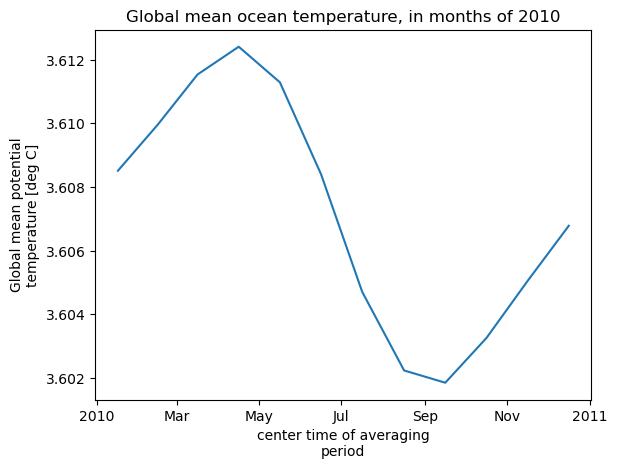



Computation completed
Time to open files, 2 processes/2 threads: 32.507508754730225 s
Time to compute, 2 processes/2 threads: 42.54342699050903 s
CPU times: user 13 s, sys: 5.15 s, total: 18.1 s
Wall time: 1min 15s


In [7]:
%%time

# Open 12 monthly files (temp/salinity)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

time_log = [time.time()]

## open list of files
TS_mon_shortname = "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"
file_dict = ea.ecco_podaac_access(TS_mon_shortname,\
                                    StartDate="2010-01",EndDate="2010-12",\
                                    mode='s3_open')

## open files in workspace
ds = xr.open_mfdataset(file_dict[TS_mon_shortname],\
                       data_vars='minimal',coords='minimal',\
                       compat='override',\
                       chunks={'time':1,'k':10,'tile':13,'j':90,'i':90})

## repeat above with the grid file
grid_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
grid_file_dict = ea.ecco_podaac_access(grid_shortname,\
                                         mode='s3_open')
ds_grid = xr.open_mfdataset(grid_file_dict[grid_shortname],chunks={'k':10,'tile':13,'j':90,'i':90})

time_log.append(time.time())
time_to_open_files = np.diff(np.asarray(time_log)[-2:])[0]


# Compute global mean temperature at each time

time_log.append(time.time())

## compute volumes of each cell
cell_vol = ds_grid.hFacC*ds_grid.rA*ds_grid.drF

## mean temperature weighted by the volume of each cell
total_vol = cell_vol.sum().compute()
theta_global_mean = (cell_vol*ds.THETA).sum(dim=["k","tile","j","i"])/\
                        total_vol
theta_global_mean = theta_global_mean.compute()

## plot global mean temperature
theta_global_mean = theta_global_mean.assign_attrs(long_name='Global mean potential temperature',units='deg C')
curr_plot = theta_global_mean.plot()
plt.title('Global mean ocean temperature, in months of 2010')
plt.show()

time_log.append(time.time())
time_to_compute = np.diff(np.asarray(time_log)[-2:])[0]

client.close()

print('\n\nComputation completed')
print(f'Time to open files, 2 processes/2 threads: {time_to_open_files} s')
print(f'Time to compute, 2 processes/2 threads: {time_to_compute} s')

In this case we saved a little bit of time opening the files with multiple threads, but this was more than offset by the additional overhead from the *distributed* client during the computation (note the warning above about sending a large graph). So here it would be better to not use *distributed* for the computation.

### Method 2: Download (get) S3 files to local instance

While the ability to open files from S3 without using up disk storage on your instance is useful, it is often more convenient to just download a copy of the files you need to your instance. As you might expect, since you are already on the cloud it can be a lot quicker to download the files than it would be to your own machine, and computations are also more efficient when the source data are already local to your instance.

To download files to our local instance, use mode = `s3_get`. Note that by default files are downloaded to the the path `~/Downloads/ECCO_V4r4_PODAAC/{ShortName}/{filename}.nc`, but this can be changed using the `download_root_dir` option.

created download directory /home/jpluser/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2010-01-02,2010-12-31'}

Total number of matching granules: 12
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-01_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-02_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-03_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-04_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-05_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-06_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-07_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-08_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-09_ECCO_V4r4_native_

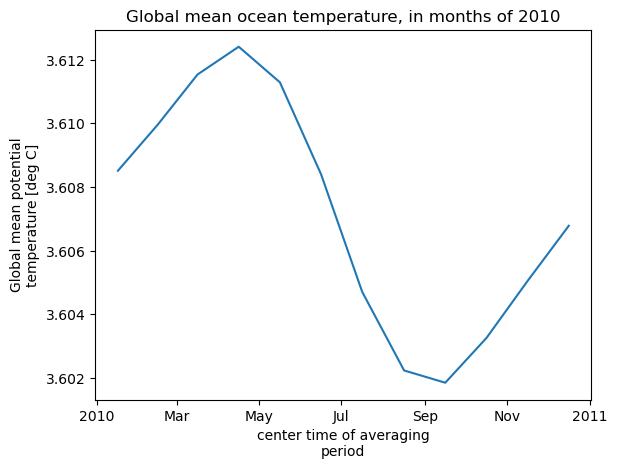



Computation completed
Time to download files: 7.0586652755737305 s
Time to compute: 3.8432106971740723 s
CPU times: user 5.47 s, sys: 810 ms, total: 6.28 s
Wall time: 10.9 s


In [9]:
%%time

# # un-comment and run this block if you just restarted the kernel
# import numpy as np
# import xarray as xr
# import matplotlib.pyplot as plt
# import time


# Get/download 12 monthly files (temp/salinity) and grid parameters file to user's instance

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

time_log = [time.time()]

## download files to instance
TS_mon_shortname = "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"
file_dict = ea.ecco_podaac_access(TS_mon_shortname,\
                                    StartDate="2010-01",EndDate="2010-12",\
                                    mode='s3_get',\
                                    n_workers=2)

## open files in workspace
ds = xr.open_mfdataset(file_list,\
                       data_vars='minimal',coords='minimal',\
                       compat='override',\
                       chunks={'time':1,'k':10,'tile':13,'j':90,'i':90})

## repeat above with the grid file
grid_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
grid_file_dict = ea.ecco_podaac_access(grid_shortname,\
                                         mode='s3_get',\
                                         n_workers=2)
ds_grid = xr.open_mfdataset(grid_file_dict[grid_shortname],chunks={'k':10,'tile':13,'j':90,'i':90})

time_log.append(time.time())
time_to_get_files = np.diff(np.asarray(time_log)[-2:])[0]


# Compute global mean temperature at each time

time_log.append(time.time())

## compute volumes of each cell
cell_vol = ds_grid.hFacC*ds_grid.rA*ds_grid.drF

## mean temperature weighted by the volume of each cell
total_vol = cell_vol.sum().compute()
theta_global_mean = (cell_vol*ds.THETA).sum(dim=["k","tile","j","i"])/\
                        total_vol
theta_global_mean = theta_global_mean.compute()

## plot global mean temperature
theta_global_mean = theta_global_mean.assign_attrs(long_name='Global mean potential temperature',units='deg C')
curr_plot = theta_global_mean.plot()
plt.title('Global mean ocean temperature, in months of 2010')
plt.show()

time_log.append(time.time())
time_to_compute = np.diff(np.asarray(time_log)[-2:])[0]

print('\n\nComputation completed')
print(f'Time to download files: {time_to_get_files} s')
print(f'Time to compute: {time_to_compute} s')

Downloading the files to your instance before doing computations with them is a clear time-saver: 10.9 seconds total time, vs. at least 40 seconds with the other methods. So if you have the storage space on your instance, method 2 is usually the way to go.


## Optimizing data access with available instance storage

We just saw in the last section that downloading data to your instance before computations saves time, but smaller AWS instances can be limited by available storage as well as memory. How can you know (before downloading) that you have the storage available to download files? If you specify mode = `s3_get_ifspace`, the *ecco_access* functions will either download to your local instance (like `s3_get`) or access the data "remotely" from S3 without storing the files on your instance (like `s3_open`).

Which mode is invoked depends on how much available storage you have; the **max_avail_frac** option specifies the threshold to decide whether you have enough storage to download the files and store them locally. The default value of **max_avail_frac** is 0.5.

Let's repeat the calculation that was done above by invoking this function, first removing the files if they are already on disk to replicate the previous example in Method 2 as closely as possible. We're also going to use the `ecco_podaac_to_xrdataset` function from `ecco_access`, which conveniently uses `ecco_podaac_access` and `xarray`'s `open_mfdataset` in a single function call!

{'ShortName': 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2010-01-02,2010-12-31'}
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '2010-01-01,2010-12-31'}
Size of files to be downloaded to instance is 0.202 GB,
which is 0.22% of the 91.405 GB available storage.
Proceeding with file downloads from S3
created download directory /home/jpluser/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-01_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-02_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-03_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-04_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-05_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-06_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mea

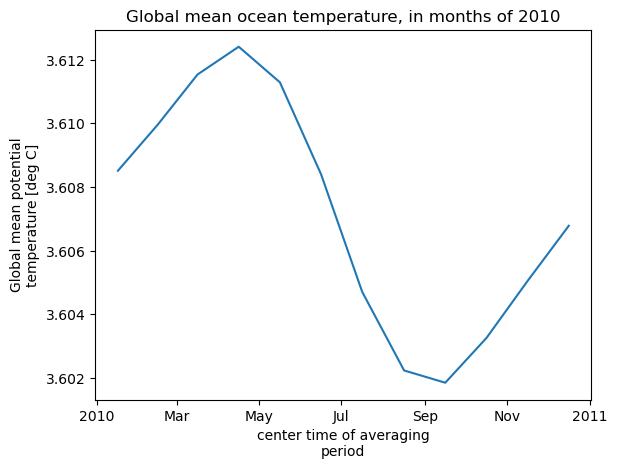



Computation completed
Time to download files: 5.2829673290252686 s
Time to compute: 3.733795166015625 s
CPU times: user 5.25 s, sys: 761 ms, total: 6.01 s
Wall time: 9.02 s


In [11]:
%%time

# # un-comment and run this block if you just restarted the kernel
# import numpy as np
# import xarray as xr
# import matplotlib.pyplot as plt
# import time


# if files to be downloaded are already on the instance, remove them
import os
from os.path import join,expanduser
import glob
TS_2010_files = glob.glob(join(expanduser('~'),'Downloads','ECCO_V4r4_PODAAC',\
                               'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4','*2010-*.nc'))
for file in TS_2010_files:
    os.remove(file)
grid_file = glob.glob(join(expanduser('~'),'Downloads','ECCO_V4r4_PODAAC',\
                                      'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4','*.nc'))
for file in grid_file:
    os.remove(file)



# Get/download 12 monthly files (temp/salinity) and grid parameters file to user's instance

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

time_log = [time.time()]

ShortNames_list = ["ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"]

## download files to instance and return as a dictionary containing 2 xarray Datasets
ds_dict = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                       StartDate="2010-01",EndDate="2010-12",\
                                       mode='s3_get_ifspace',\
                                       max_avail_frac=0.5,n_workers=2)

## open files in workspace
ds = ds_dict[ShortNames_list[0]].chunk({'time':1,'k':10,'tile':13,'j':90,'i':90})

ds_grid = ds_dict[ShortNames_list[1]].chunk({'k':10,'tile':13,'j':90,'i':90})

time_log.append(time.time())
time_to_get_files = np.diff(np.asarray(time_log)[-2:])[0]


# Compute global mean temperature at each time

time_log.append(time.time())

## compute volumes of each cell
cell_vol = ds_grid.hFacC*ds_grid.rA*ds_grid.drF

## mean temperature weighted by the volume of each cell
total_vol = cell_vol.sum().compute()
theta_global_mean = (cell_vol*ds.THETA).sum(dim=["k","tile","j","i"])/\
                        total_vol
theta_global_mean = theta_global_mean.compute()

## plot global mean temperature
theta_global_mean = theta_global_mean.assign_attrs(long_name='Global mean potential temperature',units='deg C')
curr_plot = theta_global_mean.plot()
plt.title('Global mean ocean temperature, in months of 2010')
plt.show()

time_log.append(time.time())
time_to_compute = np.diff(np.asarray(time_log)[-2:])[0]

print('\n\nComputation completed')
print(f'Time to download files: {time_to_get_files} s')
print(f'Time to compute: {time_to_compute} s')

Notice that the total size of the downloads was only 0.22% of the available storage, much less than the 50% threshold that would trigger the to be opened from S3 rather than downloading to the instance. Proceeding with the downloads, we finished the computation in about the same time as using mode = `s3_get`, but more quickly than when we used mode = `s3_open`.